# Demo of Diffusion Modelling by Gaussian Mixture Model

Author: Binxu Wang (binxu_wang@hms.harvard.edu)

Data: June.19th, 2022

* MLFS Day 1: Score, Diffusion process, Reverse Diffusion
* MLFS Day 2: Score matching, approximating score with Neural Networks.


Let's first choose one **simple yet expressive model** as our toy -- Gaussian mixture in $n$ dim. 

**Simplicity**
* Density and score are analytically tractable and straigtforward to evaluate. 
* Gaussian mixture remains Gaussian mixture under diffusion process. 

**Expressivity**
* As we know, given enough Gaussian bumps you can approximate any distribution. [this post](https://stats.stackexchange.com/questions/446351/the-approximation-power-of-gaussian-mixture-models)
* Moreover, any Gaussian kernel density estimation of a point cloud is a Gaussian Mixture! 
![](https://upload.wikimedia.org/wikipedia/commons/6/61/Synthetic_data_2D_KDE.png)



$$
p(x)=\sum_i^k\pi_i f(x;\mu_i,\Sigma_i)
$$
Let $f$ represent the Density of Multivariate Gaussian in $n$ dim. 
$$
f(x;\mu,\Sigma)=((2\pi)^n\det\Sigma)^{-1/2}\exp(-\frac12(x-\mu)^T\Sigma^{-1}(x-\mu))
$$
The weights $\sum_i\pi_i=1$. 


## Deriving the score analytically
Let's abbreviate $f_i(x):=f(x;\mu_i,\Sigma_i)$ be the Gaussian density of the component $i$
$$
\log p(x)=\log \sum_i\pi_i f_i(x)\\
$$
The score function reads
$$
\nabla_x \log p(x)=\frac{\sum_i\pi_i \nabla_x f_i(x)}{\sum_i\pi_i f_i(x)}\\
=-\frac{\sum_i\pi_i f_i(x)\Sigma_i^{-1}(x-\mu_i)}{\sum_i\pi_i f_i(x)}\\
=\sum_i w_i\nabla \log f_i(x)
$$

It is the weighted average of the gradient of the log density of each gaussian $\nabla \log f_i(x)=-\Sigma_i^{-1}(x-\mu_i)$, weighted by the participation of each component $\pi_i f_i(x)$. 

The weights, $w_i=\frac{\pi_i f_i(x)}{\sum_j\pi_j f_j(x)}=\frac{p(x|z=i)p(z=i)}{p(x)}=p(z=i|x)$.


# Day 1: Compute Score, Forward, Reverse Diffusion process

## Define the Gaussian Mixture model

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
# from numpy.random.mtrand import sample

In [ ]:
class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch. 
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])
  
  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov))
    self.RVs.append(multivariate_normal(mu, cov))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1
  
  def pdf(self, x):
    """
      probability density (PDF) at $x$. 
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    prob = np.dot(component_pdf, self.norm_weights)
    return prob
  
  def score(self, x):
    """
    Compute the score $\nabla_x \log p(x)$ for the given $x$. 
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec
    
    return scores
  
  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\nabla_x \log p(x)$ for the given $x$. 
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
    
    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights. 
      Choose sample between the branches according to the indices. 
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples


In [ ]:
def kdeplot(pnts, label="", ax=None, titlestr=None, **kwargs):
  if ax is None:
    ax = plt.gca()#figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, **kwargs)
  if titlestr is not None:
    ax.set_title(titlestr)


def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)


def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

In [ ]:
# mean and covariance of the 1,2,3 Gaussian branch.
mu1 = np.array([0,1.0])
Cov1 = np.array([[1.0,0.0],
          [0.0,1.0]])

mu2 = np.array([2.0,-1.0])
Cov2 = np.array([[2.0,0.5],
          [0.5,1.0]])

gmm = GaussianMixture([mu1,mu2],[Cov1,Cov2],[1.0,1.0])

## Visualize a Gaussian Mixture density and its score


In [ ]:
gmm_samps, rand_component, component_samples = gmm.sample(5000)
scorevecs = gmm.score(gmm_samps)

In [ ]:
print("gmm_samps ",gmm_samps.shape)
print("rand_component ",rand_component.shape)
print("all_samples ",component_samples.shape)
print("scorevecs ",scorevecs.shape)

gmm_samps  (5000, 2)
rand_component  (5000,)
all_samples  (2, 5000, 2)
scorevecs  (5000, 2)


Now we get a few variables
* `scorevecs`: $\nabla_x \log p(x)$ a vector at each datapoint $x$. 
* `gmm_samps`: shape `(N,2)` the datapoints sampled from the Gaussian Mixture.
* `rand_component`: shape `(N,)` the branch where the data came from. 
* `all_samples`: shape `(2,N,2)` the two components 


Let's look at the density first

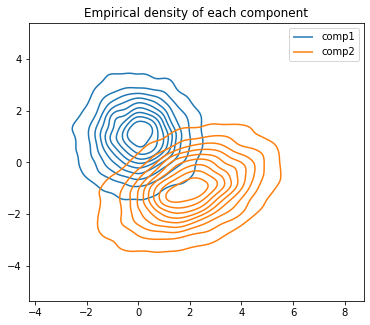

In [ ]:
figh, ax = plt.subplots(1,1,figsize=[6,6])
kdeplot(component_samples[0,:,:], label="comp1", )
kdeplot(component_samples[1,:,:], label="comp2", )
plt.title("Empirical density of each component")
plt.legend()
plt.axis("image");

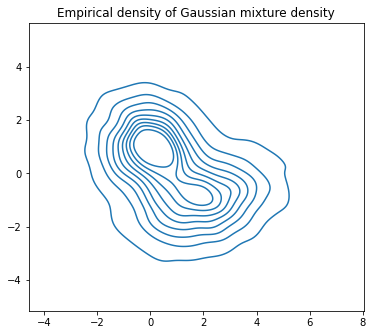

In [ ]:
figh, ax = plt.subplots(1,1,figsize=[6,6])
kdeplot(gmm_samps, )
plt.title("Empirical density of Gaussian mixture density")
plt.axis("image");

Now let's examine the composition of the score vector field to gain some intuition. We'd like to visualize 

* $\nabla \log f_i(x)$
* $w_i\nabla \log f_i(x)$, where $w_i$ is the weights computed from participation $w_i=\pi_i f_i(x)/\sum_j(\pi_j f_j(x))$
* $\nabla p(x)$

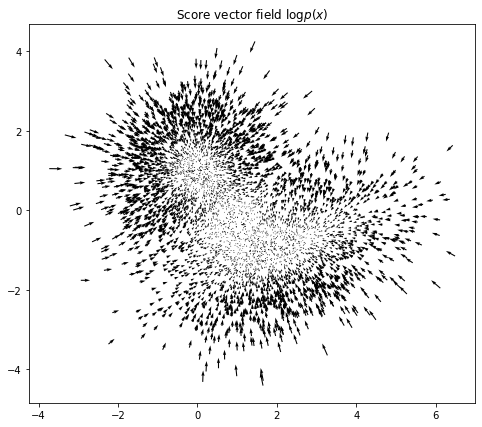

In [ ]:
plt.figure(figsize=[8,8])
quiver_plot(gmm_samps, scorevecs)
plt.title("Score vector field $\log p(x)$")
plt.axis("image");

In [ ]:
gmm_samps_few, _, _ = gmm.sample(200)
scorevecs_few = gmm.score(gmm_samps_few)
gradvec_list, participance = gmm.score_decompose(gmm_samps_few)

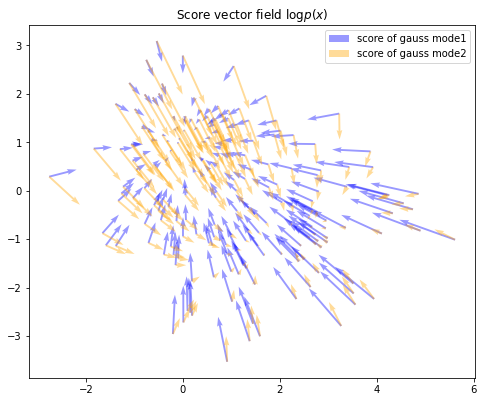

In [ ]:
plt.figure(figsize=[8,8])
quiver_plot(gmm_samps_few, gradvec_list[0], color="blue", alpha=0.4, scale=45, label="score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1], color="orange", alpha=0.4, scale=45, label="score of gauss mode2")
# quiver_plot(gmm_samps_few, scorevecs_few, scale=15, alpha=0.7, width=0.003)
plt.title("Score vector field $\log p(x)$")
plt.axis("image");
plt.legend();

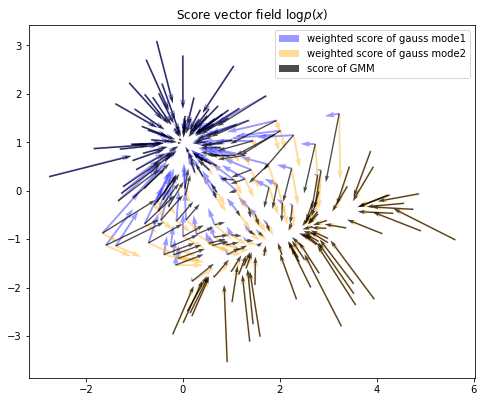

In [ ]:
plt.figure(figsize=[8,8])
quiver_plot(gmm_samps_few, gradvec_list[0]*participance[:,0:1], color="blue", alpha=0.4, scale=15, label="weighted score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1]*participance[:,1:2], color="orange", alpha=0.4, scale=15, label="weighted score of gauss mode2")
quiver_plot(gmm_samps_few, scorevecs_few, scale=15, alpha=0.7, width=0.003, label="score of GMM")
plt.title("Score vector field $\log p(x)$")
plt.axis("image");
plt.legend();

## (Forward) Diffusion Process


**Continuous SDE version of diffusion**
$$
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
$$
**Discrete Markov process version of diffusion**
$$
\mathbf{x_{t+\Delta t}} = \mathbf{x_{t}}+\sigma^t \sqrt{\Delta t} z_t
$$
$z_t\sim \mathcal N(0,I)$

The ending distribution of $x(1)$ will be approximately
$$
\mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{\sigma^2 - 1}{2 \log \sigma}\mathbf{I}\bigg)
$$

### Density during diffusion
More precisely, after $t$ time diffusion, 
$$
p(\mathbf x_t=\mathbf{x}|\mathbf x_0)=\mathcal{N}\bigg(\mathbf{x}; \mathbf x_0, \frac{\sigma^{2t} - 1}{2 \log \sigma}\mathbf{I}\bigg)
$$
We could understand $\mathbf x_t$ as $\mathbf x_0$ plus Gaussian noise, where $\beta_t=\sqrt{\frac{\sigma^{2t} - 1}{2 \log \sigma}}$, the std of the noise. $z\sim \mathcal N(0,I)$
$$
\mathbf x_t=x_0+\beta_t z
$$
For a Gaussian mixture model with $\{\pi_i,\mu_i,\Sigma_i\}$, the exact density $p(\mathbf x_t)$ at time $t$ shall still be a Gaussian Mixture with parameter $\{\pi_i,\mu_i,\Sigma_i^{(t)}\}$, where
$$
\Sigma_i^{(t)}=\Sigma_i+\frac{\sigma^{2t} - 1}{2 \log \sigma}I
$$

We denote the marginal denstiy of $x$ at time $t$, $p_t(\mathbf x)$. 

Using this analytical property, let's define a function `diffuse_gmm` that "time-travel" a `gmm` from $0\to t$

* `marginal_prob_std`, a util function output the standard deviation (std) $\beta_t$ of the conditional distribution $p(x_t|x_0)$. 
* `diffuse_gmm` takes in a `gmm` at $t=0$ and outputs the `gmm` object representing the marginal density at time $t$. 

In [ ]:
def marginal_prob_std(t, sigma):
  """Note that this std -> 0, when t->0
  So it's not numerically stable to sample t=0 in the dataset
  Note an earlier version missed the sqrt... 
  """
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) )

def marginal_prob_std_np(t, sigma):
  return np.sqrt( (sigma**(2*t) - 1) / 2 / np.log(sigma) )

In [ ]:
def diffuse_gmm(gmm, t, sigma):
  lambda_t = marginal_prob_std_np(t, sigma)**2 # variance
  noise_cov = np.eye(gmm.dim) * lambda_t
  covs_dif = [cov + noise_cov for cov in gmm.covs]
  return GaussianMixture(gmm.mus, covs_dif, gmm.weights)

### Diffusion in Action

In [ ]:
x0, _, _ = gmm.sample(1000)

sigma = 5
nsteps = 200

x_traj = np.zeros((*x0.shape, nsteps, ))
x_traj[:,:,0] = x0
dt = 1 / nsteps
for i in range(1, nsteps):
  t = i * dt
  eps_z = np.random.randn(*x0.shape)
  x_traj[:,:,i] = x_traj[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt)

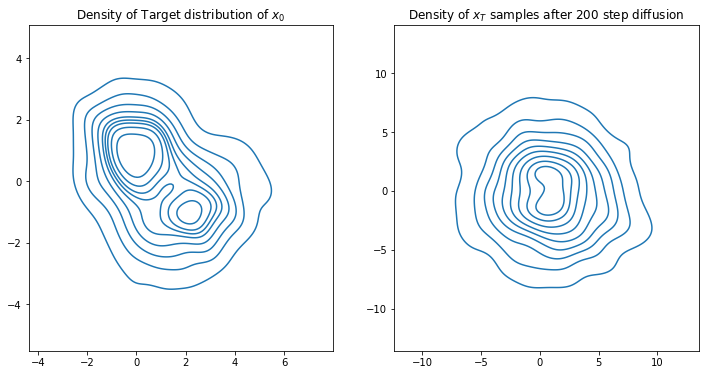

In [ ]:
figh, axs = plt.subplots(1,2,figsize=[12,6])
sns.kdeplot(x=x_traj[:,0,0], y=x_traj[:,1,0], ax=axs[0])
axs[0].set_title("Density of Target distribution of $x_0$")
plt.axis("equal")
sns.kdeplot(x=x_traj[:,0,-1], y=x_traj[:,1,-1], ax=axs[1])
axs[1].set_title(f"Density of $x_T$ samples after {nsteps} step diffusion")
plt.axis("equal");

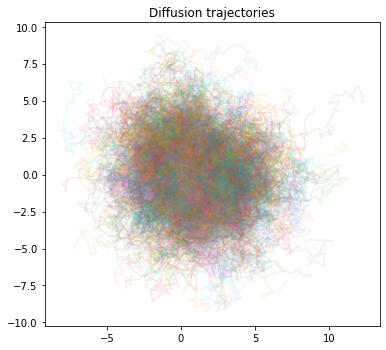

In [ ]:
figh, ax = plt.subplots(1,1,figsize=[6,6])
plt.plot(x_traj[:,0,:].T,x_traj[:,1,:].T,alpha=0.10,)
plt.title("Diffusion trajectories")
plt.axis("image")
plt.show()

### Validate the time dependent density with theory

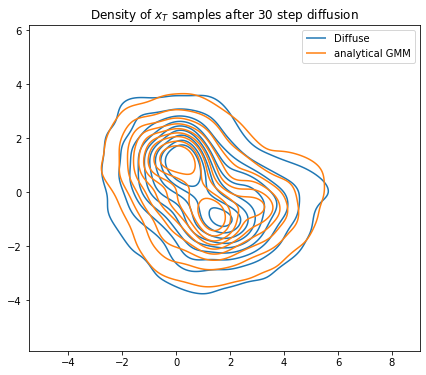

In [ ]:
t_step = 150 #@param {type:"slider", min:0, max:199, step:10}
gmm_t = diffuse_gmm(gmm, t_step / nsteps, sigma)
samps_t, _, _ = gmm_t.sample(2000)

figh, axs = plt.subplots(1,1,figsize=[7,6])
sns.kdeplot(x=x_traj[:,0,t_step], y=x_traj[:,1,t_step], ax=axs, label="Diffuse")
sns.kdeplot(x=samps_t[:,0], y=samps_t[:,1], ax=axs, label="analytical GMM")
axs.set_title(f"Density of $x_T$ samples after {t_step} step diffusion")
plt.axis("equal")
plt.legend()

## Reverse Diffusion sampling

**Continuous SDE version**
\begin{align*}
d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}.
\end{align*}

$p_t(x)$ is the marginal probability of $x_t$, the diffused density.Let's define the time dependent score function $s(\mathbf{x}_t,t)=\nabla_\mathbf{x}\log p_t(\mathbf{x}_t)$. 

**Discrete Markov chain version**
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + \sigma^{2t} s(\mathbf{x}_t,t)\Delta t + \sigma^t\sqrt{\Delta t} \mathbf{z}_t,
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, 

Now, let's implement the Markov chain version of discrete diffusion. 

In [ ]:
sampN = 1000
sigma = 5
nsteps = 400

lambdaT = (sigma**2 - 1) / (2 * np.log(sigma)) # marginal_prob_std_np(1.0, sigma)
xT = np.sqrt(lambdaT) * np.random.randn(sampN, 2)
x_traj_rev = np.zeros((*x0.shape, nsteps, ))
x_traj_rev[:,:,0] = xT
dt = 1 / nsteps
for i in range(1, nsteps):
  t = (nsteps - i) * dt # note the time fly back
  # transport the gmm to that at time $t$ and compute score at that time $\nabla \log p_t(x)$ 
  gmm_t = diffuse_gmm(gmm, t, sigma) # note the time fly back! start from the largest noise scale
  score_xt = gmm_t.score(x_traj_rev[:,:,i-1])
  eps_z = np.random.randn(*x0.shape)
  x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)

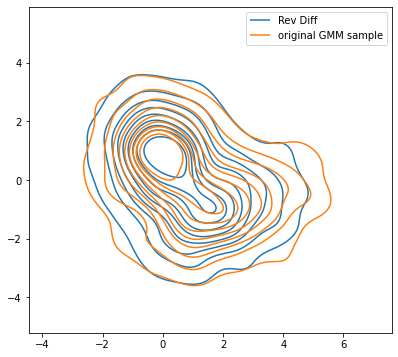

In [ ]:
figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
kdeplot(x_traj_rev[:,:,-1], "Rev Diff", )#ax=axs)
kdeplot(gmm_samps, "original GMM sample", )#ax=axs)
plt.legend()

(-5.4653091881446105,
 8.059743502501288,
 -5.596059107144443,
 4.8413415462330045)

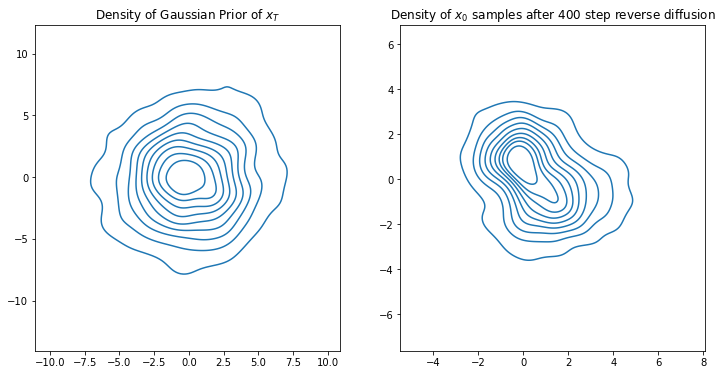

In [ ]:
figh, axs = plt.subplots(1,2,figsize=[12,6])
kdeplot(x_traj_rev[:,:,0], ax=axs[0], titlestr="Density of Gaussian Prior of $x_T$")
plt.axis("equal")
kdeplot(x_traj_rev[:,:,-1], ax=axs[1], titlestr=f"Density of $x_0$ samples after {nsteps} step reverse diffusion")
plt.axis("equal")

## Define diffusion functions
These are also answers to Day 1 exercise. 

In [ ]:
def marginal_prob_std(t, sigma):
  """Note that this std -> 0, when t->0
  So it's not numerically stable to sample t=0 in the dataset
  Note an earlier version missed the sqrt... 
  """
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) )

def marginal_prob_std_np(t, sigma):
  return np.sqrt( (sigma**(2*t) - 1) / 2 / np.log(sigma) )


def diffuse_gmm(gmm, t, sigma):
  lambda_t = marginal_prob_std_np(t, sigma)**2 # variance
  noise_cov = np.eye(gmm.dim) * lambda_t
  covs_dif = [cov + noise_cov for cov in gmm.covs]
  return GaussianMixture(gmm.mus, covs_dif, gmm.weights)


def forward_diffusion(x0, sigma=5, nsteps=200):
  x_traj = np.zeros((*x0.shape, nsteps, ))
  x_traj[:,:,0] = x0
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = i * dt
    eps_z = np.random.randn(*x0.shape)
    x_traj[:,:,i] = x_traj[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt)
  return x_traj


def reverse_diffusion_time_dep(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False):
  lambdaT = (sigma**2 - 1) / (2 * np.log(sigma))
  xT = np.sqrt(lambdaT) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, sigma)
      score_xt = gmm_t.score(x_traj_rev[:,:,i-1])
    else:
      tvec = torch.ones((sampN,)) * t
      with torch.no_grad():
        score_xt = score_model_td(torch.tensor(x_traj_rev[:,:,i-1]).float(), tvec).numpy()
    x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)
  return x_traj_rev


def reverse_diffusion(score_model, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False):
  lambdaT = (sigma**2 - 1) / (2 * np.log(sigma))
  xT = np.sqrt(lambdaT) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt # t = i * dt
    eps_z = np.random.randn(*xT.shape)
    if exact:
      score_xt = score_model.score(x_traj_rev[:,:,i-1])
    else:
      with torch.no_grad():
        score_xt = score_model(torch.tensor(x_traj_rev[:,:,i-1]).float()).numpy()
    x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)
  return x_traj_rev

# Day 2: Score matching and Neural Network Approximation

Now we empirically validated that the math behind Diffusion works out! But this relies on the explicit density $p(x)$ and score $\nabla p_t(x)$. 

Can we approximate these with neural network, and further learn them from data?

Two questions we need to ask for NN
* **Representation**: Can NN of a given architecture represent certain function (given infinite data / exact score)?
* **Learning**: Can we learn it from discrete samples from the data?

### (Explicit) Score Matching
Naive way to approximate the score function is through supervised learning. Since we want a function $s_\theta(x,t)\approx \nabla_x \log p_t(x)$, lets just minimize the L2 error between LHS and RHS. 
$$
\frac 12\|s_\theta(x,t)-\nabla_x\log p_t(x)\|^2
$$
Given a neural network $s_\theta$ with infinite appoximation power, the global minimum of this objective is $0$ error for all $(x,t)\in \mathbb R^2\times[0,1s]$. 

However, given finite data and approximation power, error in some domain in $(x,t)$ is prioritized. One method is to sample $t\in[0,1]$ uniformly and $x\sim p_t(x)$ and minimize this objective (Explicit Score Matching) which emphasizes the error under the mass $p_t(x)$. Alternative way to sample $(x,t)$ emphasize the precision of approximation in other domains.
$$
J_{ESM}(\theta)=\int_0^1dt\mathbb E_{x\sim p_t(x)}\frac 12\|s_\theta(x,t)-\nabla_x\log p_t(x)\|^2
$$


For the **first section**, we'd like to train a neural network that minimize this objective and approximate the analytical score for Gaussian Mixture Model. You will see how these networks are usually designed and how the training works.

### Denoising Score Matching
How to fit the score based on the samples, when we have no access to the exact scores? 

One objective to learn score is called denoising score matching. Mathematically, it utilized this **equivalence relationship** of the following objectives. (A short proof in [my blog post](https://animadversio.github.io/academic_notes/note-on-equiv-score-matching-objective)) 

$$
J_{DSM}(\theta)=\mathbb E_{\tilde x,x\sim p_\sigma(\tilde x,x)}\frac 12\|s_\theta(\tilde x)-\nabla_\tilde x\log p_\sigma(\tilde x\mid x)\|^2\\
J_{ESM}(\theta)=\mathbb E_{\tilde x\sim p_\sigma(\tilde x)}\frac 12\|s_\theta(\tilde x)-\nabla_\tilde x\log p_\sigma(\tilde x)\|^2
$$
They are equivalent in the sense that they share the same global minima,and $J_{DSM}(\theta)=J_{ESM}(\theta)+C$. Note that at the minimum the $J_{DSM}(\theta)> 0$. (**Why it cannot reach zero?**)



In practise, it amounts to sample $x$ from data distribution, add noise with $\sigma$ and denoise it. 

Since we have at time $t$, $p_t(\tilde x\mid x)= \mathcal N(x,\beta^2_t I)$, 
$$
\nabla_\tilde x \log p(\tilde x|x)=-\frac{1}{\beta_t^2}(\tilde x -x)
$$
then $\tilde x=x+\beta_t z,z\sim \mathcal N(0,I)$, the objective simplifies into 
$$
\mathbb E_{x\sim p(x)}\mathbb E_{z\sim \mathcal N(0,I)}\frac 12\|s_\theta(x+\beta_t z)+\frac{1}{\beta_t^2}(x+\beta_t z -x)\|^2\\
\mathbb E_{x\sim p(x)}\mathbb E_{z\sim \mathcal N(0,I)}\frac 12\|s_\theta(x+\beta_t z)+\frac{1}{\beta_t}z\|^2
$$


Finally, in the time dependent score model $s(x,t)$, to learn this for any time $t\in [\epsilon,1]$, we integrate over all $t$. 
$$
\int_\epsilon^1dt \mathbb E_{x\sim p(x)}\mathbb E_{z\sim \mathcal N(0,I)}\frac 12\|s_\theta(x+\beta_t z, t)+\frac{1}{\beta_t}z\|^2
$$
(the $\epsilon$ is set to ensure numerical stability, as $t\to 0,\beta_t\to 0$)
Now all the expectations could be easily evaluated by sampling. 


It is common to add a weighting factor for different $t$ for better training. 
$$
\int_\epsilon^1dt \lambda(t)\mathbb E_{x\sim p(x)}\mathbb E_{z\sim \mathcal N(0,I)}\frac 12\|s_\theta(x+\beta_t z, t)+\frac{1}{\beta_t}z\|^2
$$
In our case we will use $\lambda(t)=\beta_t^2$. 
$$
\int_\epsilon^1dt \mathbb E_{x\sim p(x)}\mathbb E_{z\sim \mathcal N(0,I)}\frac 12\|\beta_t s_\theta(x+\beta_t z, t)+z\|^2
$$



## Design the neural network and objective

### Structure of the time-dependent Score

Before building and training models, let's see if there is any structure we can use! 

The time dependent score function $s(x,t):\mathbb R^2\times [0,1]\to\mathbb R^2,(x,t)\mapsto \nabla_x \log p_t(x)$. So let's empirically evaluate how the score generally change with time. 

In [ ]:
def sample_X_and_score(gmm, trainN=10000, testN=2000):
  X_train,_,_ = gmm.sample(trainN)
  y_train = gmm.score(X_train)
  X_test,_,_ = gmm.sample(testN)
  y_test = gmm.score(X_test)
  X_train_tsr = torch.tensor(X_train).float()
  y_train_tsr = torch.tensor(y_train).float()
  X_test_tsr = torch.tensor(X_test).float()
  y_test_tsr = torch.tensor(y_test).float()
  return X_train_tsr, y_train_tsr, X_test_tsr, y_test_tsr


def sample_X_and_score_t_depend(gmm, trainN=10000, testN=2000, sigma=5, partition=20, EPS=0.02):
  """
  Uniformly partition [0,1] and sample t from it, and then 
  sample x~ p_t(x) and compute \nabla \log p_t(x)
  finally return the dataset x, score, t (train and test)
  """
  trainN_part, testN_part = trainN //partition, testN //partition
  X_train_col, y_train_col, X_test_col, y_test_col, T_train_col, T_test_col = [], [], [], [], [], []
  for t in np.linspace(EPS, 1.0, partition):
    gmm_dif = diffuse_gmm(gmm, t, sigma)
    X_train_tsr, y_train_tsr, X_test_tsr, y_test_tsr = \
      sample_X_and_score(gmm_dif, trainN=trainN_part, testN=testN_part, )
    T_train_tsr, T_test_tsr = t * torch.ones(trainN_part), t * torch.ones(testN_part)
    X_train_col.append(X_train_tsr)
    y_train_col.append(y_train_tsr)
    X_test_col.append(X_test_tsr)
    y_test_col.append(y_test_tsr)
    T_train_col.append(T_train_tsr)
    T_test_col.append(T_test_tsr)
  X_train_tsr = torch.cat(X_train_col, dim=0)
  y_train_tsr = torch.cat(y_train_col, dim=0)
  X_test_tsr = torch.cat(X_test_col, dim=0)
  y_test_tsr = torch.cat(y_test_col, dim=0)
  T_train_tsr = torch.cat(T_train_col, dim=0)
  T_test_tsr = torch.cat(T_test_col, dim=0)
  return X_train_tsr, y_train_tsr, T_train_tsr, X_test_tsr, y_test_tsr, T_test_tsr 

In [ ]:
sigma = 10
X_train, y_train, T_train, X_test, y_test, T_test = \
  sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=10000, testN=2000, 
                              partition=100, EPS=0.0001)


[Text(0, 0.5, 'norm x'),
 Text(0.5, 0, 'diffusion time t'),
 Text(0.5, 1.0, 'Sample norm / std ~ time')]

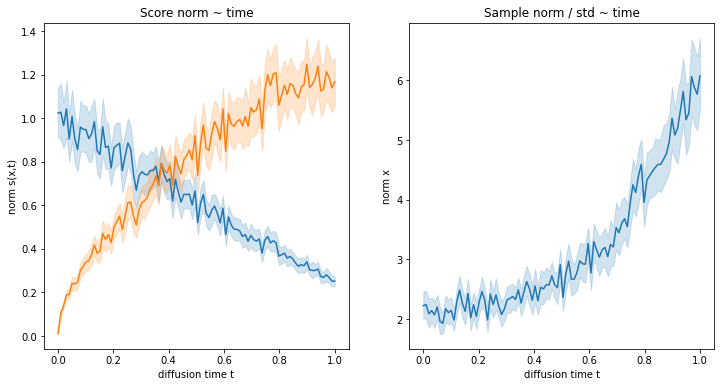

In [ ]:
score_norm = y_train.norm(dim=1)
samp_norm = X_train.norm(dim=1)
fig,axs= plt.subplots(1,2,figsize=[12,6])
sns.lineplot(x=T_train, y=score_norm, ax=axs[0])
sns.lineplot(x=T_train, y=score_norm * marginal_prob_std(T_train, sigma), ax=axs[0]) # (sigma**(T_train))
axs[0].set(xlabel="diffusion time t", ylabel="norm s(x,t)", title="Score norm ~ time")
sns.lineplot(x=T_train, y=samp_norm, ax=axs[1])
axs[1].set(xlabel="diffusion time t", ylabel="norm x", title="Sample norm / std ~ time")

### Neural network architecture

In [ ]:
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss

In [ ]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class ScoreModel_Time(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ):
    super().__init__()
    self.embed = GaussianFourierProjection(10, scale=1)
    self.net = nn.Sequential(nn.Linear(12, 50),
               nn.Tanh(),
               nn.Linear(50,50),
               nn.Tanh(),
               nn.Linear(50,2))
    self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

  def forward(self, x, t):
    t_embed = self.embed(t)
    pred = self.net(torch.cat((x,t_embed),dim=1))
    pred = pred / self.marginal_prob_std_f(t)[:, None,] # a trick / inductive bias we build in! 
    return pred

## Approximate analytical score with a neural network

Implement the Explicit Score Matching loss function (MSE)
* Extra point, what if you weight the loss of different time using $\lambda(t)=\beta_t^2$

In [ ]:
sigma = 10
X_train, y_train, T_train, X_test, y_test, T_test = \
  sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=100000, testN=2000, 
                              partition=1000, EPS=0.0001)

In [ ]:
sigma = 10
score_model_analy = ScoreModel_Time(sigma=sigma, )
optim = Adam(score_model_analy.parameters(), lr=0.001)
pbar = tqdm.notebook.trange(250)
std_vec = marginal_prob_std(T_train, sigma)
for ep in pbar:
  y_pred = score_model_analy(X_train, T_train)
  loss = ... # Implement the loss using y_pred, y_train
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")
  if ep % 25==0:
    y_pred_test = score_model_analy(X_test, T_test)
    loss_test = ... # Implement the loss using y_pred_test, y_test
    print(f"step {ep} test loss {loss.item():.3f}")
    

  0%|          | 0/250 [00:00<?, ?it/s]

AttributeError: ignored

In [ ]:
x_traj_rev_analy_pred = reverse_diffusion_time_dep(score_model_analy, sampN=2000, sigma=sigma)

In [ ]:
x_traj_rev = reverse_diffusion_time_dep(gmm, sampN=2000, sigma=sigma, exact=True)

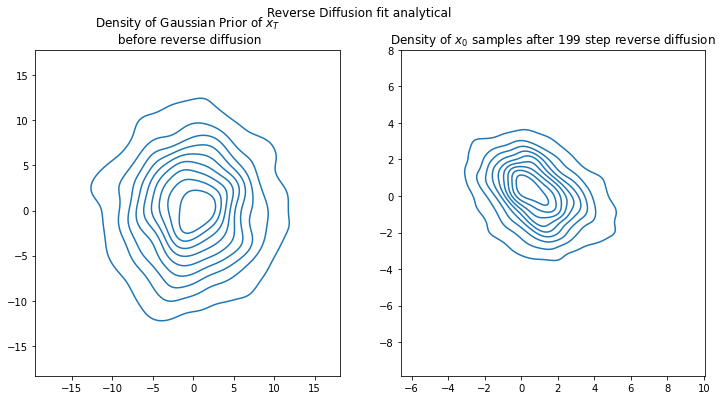

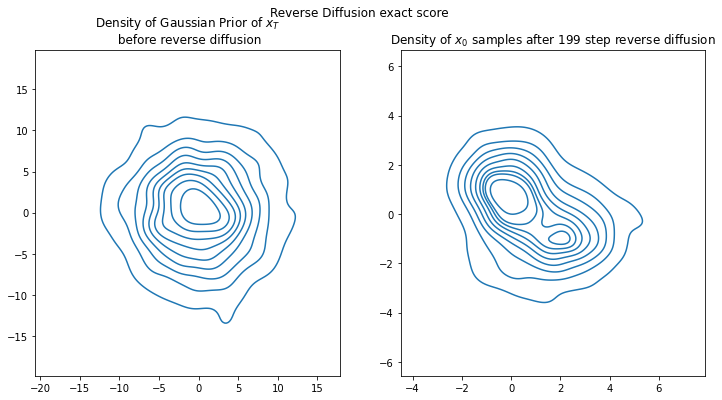

In [ ]:
visualize_diffusion_distr(x_traj_rev_analy_pred, explabel="Reverse Diffusion fit analytical");
visualize_diffusion_distr(x_traj_rev, explabel="Reverse Diffusion exact score");

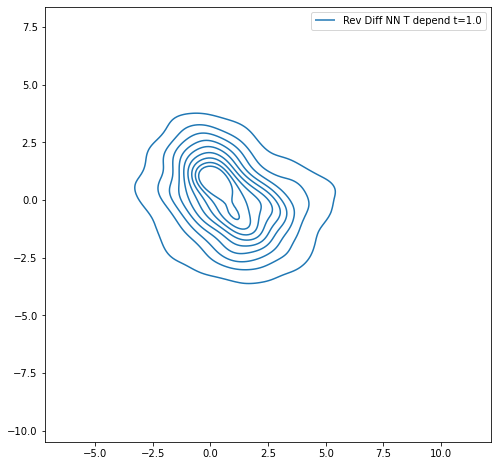

In [ ]:
fig,ax = plt.subplots(figsize=[8,8])
kdeplot(x_traj_rev_analy_pred[:,:,-1], "Rev Diff NN T depend t=1.0", )
# kdeplot(x_traj_rev_analy_pred[:,:,100], "Rev Diff NN T depend t=0.5", )
# kdeplot(x_traj_rev_analy_pred[:,:,0], "Rev Diff NN T depend t=0.0", )
plt.axis("equal")
plt.legend()

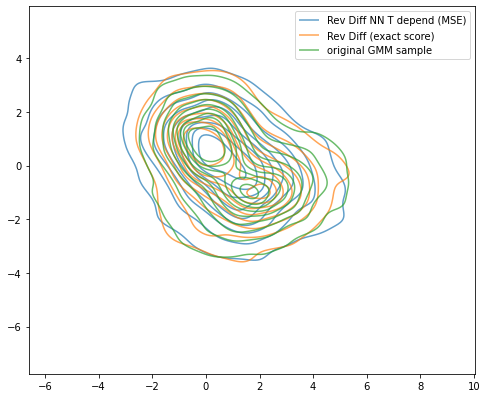

In [ ]:
fig,ax = plt.subplots(figsize=[8,8])
kdeplot(x_traj_rev_analy_pred[:,:,-1], "Rev Diff NN T depend (MSE)", alpha=0.7)
kdeplot(x_traj_rev[:,:,-1], "Rev Diff (exact score)", alpha=0.7)#ax=axs)
kdeplot(gmm_samps, "original GMM sample", alpha=0.7)#ax=axs)
plt.axis("image")
plt.legend()
plt.show()

### Incorrect example: time independent score

In [ ]:
class ScoreModel_noTime(nn.Module):
  def __init__(self, ):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2,50),
               nn.Tanh(),
               nn.Linear(50,50),
               nn.Tanh(),
               nn.Linear(50,2))

  def forward(self, x,):
    return self.net(x)

In [ ]:
X_train_tsr, y_train_tsr, X_test_tsr, y_test_tsr = sample_X_and_score(gmm)

In [ ]:
score_model = ScoreModel_noTime()

In [ ]:
optim = Adam(score_model.parameters(), lr=0.01)
loss_fun = MSELoss()
pbar = tqdm.notebook.trange(200)
for ep in pbar:
  y_pred = score_model(X_train_tsr)
  loss = loss_fun(y_train_tsr, y_pred)
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")

  0%|          | 0/200 [00:00<?, ?it/s]

step 0 loss 0.599


In [ ]:
x_traj_rev_pred = reverse_diffusion(score_model, sampN=1000, sigma=5, nsteps=200, ndim=2)

(-3.2811939802896677, 6.250744423050083, -4.501016012928149, 4.03220309845558)

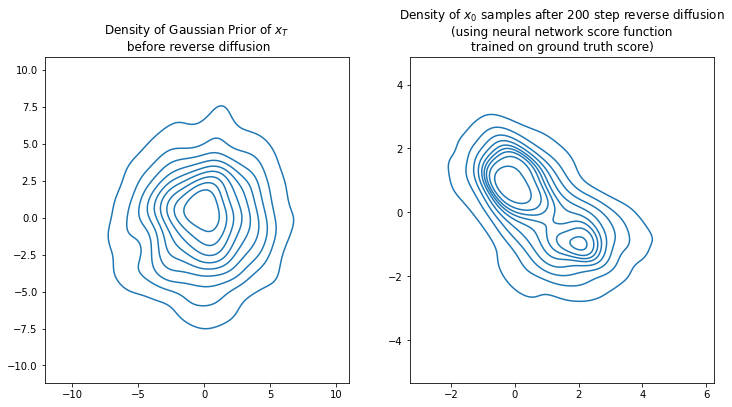

In [ ]:
figh, axs = plt.subplots(1,2,figsize=[12,6])
sns.kdeplot(x=x_traj_rev_pred[:,0,0], y=x_traj_rev_pred[:,1,0], ax=axs[0])
axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
plt.axis("equal")
sns.kdeplot(x=x_traj_rev_pred[:,0,-1], y=x_traj_rev_pred[:,1,-1], ax=axs[1])
axs[1].set_title(f"Density of $x_0$ samples after {nsteps} step reverse diffusion\n(using neural network score function\ntrained on ground truth score)")
plt.axis("equal")

(-4.3047836947383455,
 7.440759249051234,
 -5.407144921939754,
 5.6150304588093185)

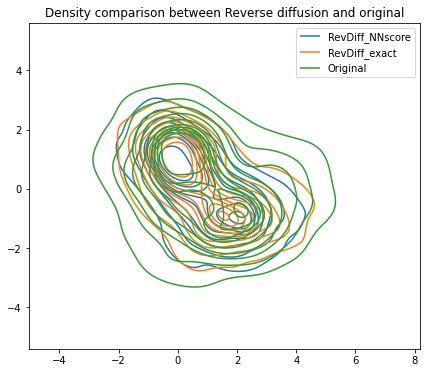

In [ ]:
figh, ax = plt.subplots(1,1,figsize=[7,6])
sns.kdeplot(x=x_traj_rev_pred[:,0,-1], y=x_traj_rev_pred[:,1,-1], ax=ax, label="RevDiff_NNscore")
sns.kdeplot(x=x_traj_rev[:,0,-1], y=x_traj_rev[:,1,-1], ax=ax, label="RevDiff_exact")
sns.kdeplot(x=gmm_samps[:,0], y=gmm_samps[:,1], ax=ax, label="Original")
plt.legend()
ax.set_title(f"Density comparison between Reverse diffusion and original")
plt.axis("equal")

## Learn Score model from samples (Denoising Score matching)

Now let's define our objective function to fit the model score. 

In [ ]:
def loss_fn(model, x, marginal_prob_std_f, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  raise NotImplementedError
  ...
  return loss

In [ ]:
X_train_samp, _, _ = gmm.sample(N=5000)
X_train_samp = torch.tensor(X_train_samp).float()

In [ ]:
sigma = 10
score_model_td = ScoreModel_Time(sigma=sigma)
marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
optim = Adam(score_model_td.parameters(), lr=0.01)
pbar = tqdm.notebook.trange(500) # 5k samples for 500 iterations.
for ep in pbar:
  loss = loss_fn(score_model_td, X_train_samp, marginal_prob_std_f, 0.05)
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")

  0%|          | 0/500 [00:00<?, ?it/s]

step 0 loss 2.057


In [ ]:
score_pred_test = score_model_td(X_train, T_train)

In [ ]:
x_traj_rev_appr_denois = reverse_diffusion_time_dep(score_model_td, sampN=1000, 
                              sigma=sigma, nsteps=200, ndim=2)

In [ ]:
x_traj_rev_exact = reverse_diffusion_time_dep(gmm, sampN=1000, 
                              sigma=5, nsteps=200, ndim=2, exact=True)

(-4.267996528315049, 7.544730849003575, -6.790984903287321, 4.663704761886774)

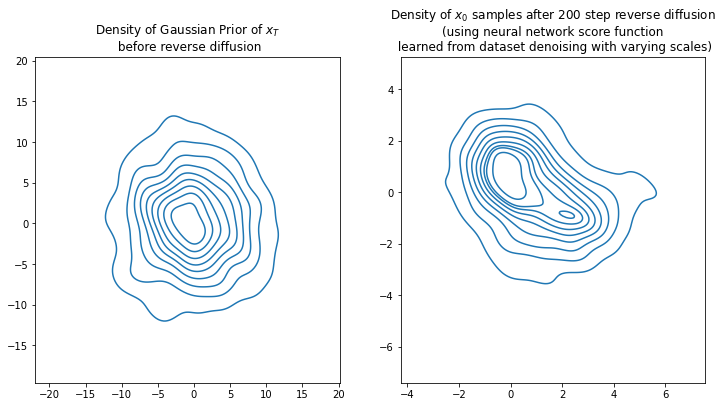

In [ ]:
figh, axs = plt.subplots(1,2,figsize=[12,6])
kdeplot(x_traj_rev_appr_denois[:,:,0], ax=axs[0],)
axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
plt.axis("equal")
kdeplot(x_traj_rev_appr_denois[:,:,-1], ax=axs[1],)
axs[1].set_title(f"Density of $x_0$ samples after {nsteps} step reverse diffusion\n(using neural network score function\n learned from dataset denoising with varying scales)")
plt.axis("equal")

(-6.600277063463501,
 10.04774028776019,
 -7.7635717152965285,
 5.9363759805555425)

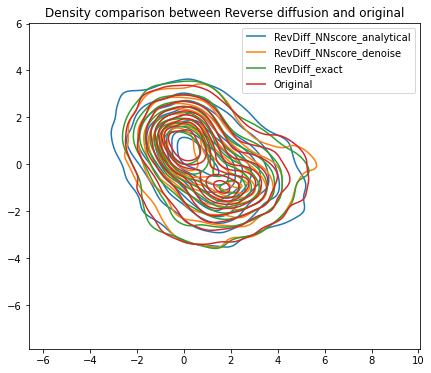

In [ ]:
figh, ax = plt.subplots(1,1,figsize=[7,6])
# sns.kdeplot(x=x_traj_rev_pred[:,0,-1], y=x_traj_rev_pred[:,1,-1], ax=ax, label="RevDiff_NNscore")
# kdeplot(x_traj_rev_exact[:,:,-1], label="RevDiff_exact m")
kdeplot(x_traj_rev_analy_pred[:,:,-1], label="RevDiff_NNscore_analytical")
kdeplot(x_traj_rev_appr_denois[:,:,-1], label="RevDiff_NNscore_denoise")
kdeplot(x_traj_rev[:,:,-1], label="RevDiff_exact")
kdeplot(gmm_samps[:,:,], label="Original")
plt.legend()
ax.set_title(f"Density comparison between Reverse diffusion and original")
plt.axis("equal")

## Fun time! Reverse diffusion modelling any Gaussian Mixture

In [ ]:
# feel free to change this part and define your gaussian mixture
mu1 = np.array([0,1.0])
Cov1 = np.array([[1.0,0.2],
          [0.2,2.0]])
mu2 = np.array([2.0,-3.5])
Cov2 = np.array([[2.0,-1.0],
          [-1.0,2.0]])
mu3 = np.array([-6.5,-5.0])
Cov3 = np.array([[4.0,0.5],
          [0.5,2.0]])
mu4 = np.array([-5.5,5.0])
Cov4 = np.array([[1.0,1.0],
          [1.0,3.0]])
gmm3 = GaussianMixture([mu1,mu2,mu3,mu4],[Cov1,Cov2,Cov3,Cov4],[1.0,1.0,1.0,1.0])

In [ ]:
gmm_samps3, _, _ = gmm3.sample(5000)
scorevecs3 = gmm3.score(gmm_samps3)

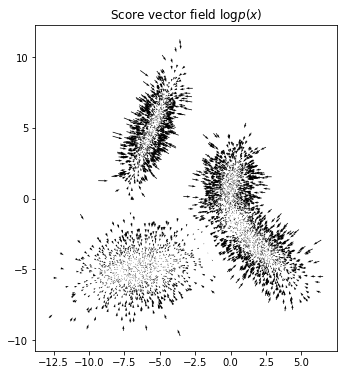

In [ ]:
plt.figure(figsize=[6,6])
quiver_plot(gmm_samps3, scorevecs3)
plt.title("Score vector field $\log p(x)$")
plt.axis("image");

(-15.626990508933183, 9.31397571357351, -12.72114556467707, 14.256778154207039)

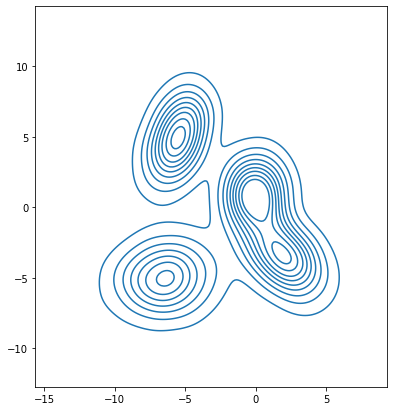

In [ ]:
plt.figure(figsize=[7,7])
kdeplot(gmm_samps3, label="True distr.")
plt.axis("image")

### With Analytical Time dependent score

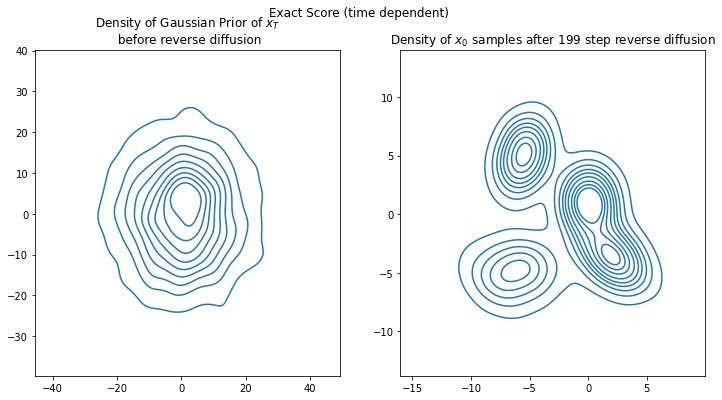

In [ ]:
x_traj_rev3 = reverse_diffusion_time_dep(gmm3, sampN=2000, sigma=25, nsteps=200, ndim=2, exact=True)
figh = visualize_diffusion_distr(x_traj_rev3, explabel="Exact Score (time dependent)")

### Weighted Denoising Objective Trained NN score 

Let's sample a dataset of $X$ and its score $y$.

In [ ]:
X_train_tsr3, y_train_tsr3, _, _ = sample_X_and_score(gmm3, trainN=20000)

In [ ]:
sigma = 25
score_model_td3 = ScoreModel_Time(sigma=sigma, )
marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
optim = Adam(score_model_td3.parameters(), lr=0.005)
pbar = tqdm.notebook.trange(750)
for ep in pbar:
  loss = loss_fn(score_model_td3, X_train_tsr3, marginal_prob_std_f, 0.05)
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")

  0%|          | 0/750 [00:00<?, ?it/s]

step 0 loss 1.880


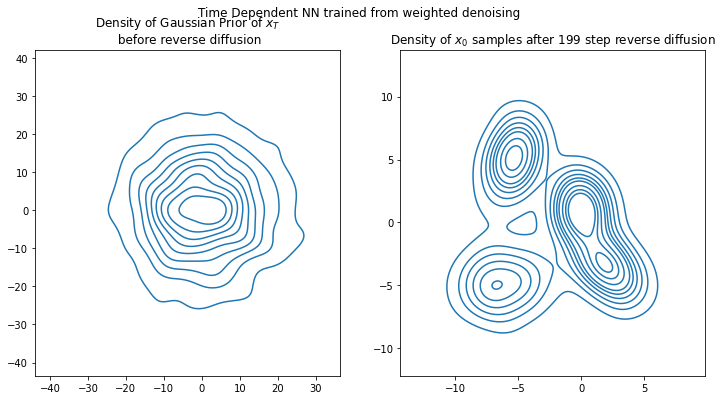

In [ ]:
x_traj_denoise3 = reverse_diffusion_time_dep(score_model_td3, sampN=2000, sigma=25, nsteps=200, ndim=2, exact=False)
figh = visualize_diffusion_distr(x_traj_denoise3, explabel="Time Dependent NN trained from weighted denoising")

### Approximating analytical time-dependent score (NN Model)

In [ ]:
sigma = 25
X_train3, y_train3, T_train3, X_test3, y_test3, T_test3 = \
  sample_X_and_score_t_depend(gmm3, sigma=sigma, trainN=50000, testN=2000, 
                              partition=500, EPS=0.0001)

score_model_analy3 = ScoreModel_Time(sigma=sigma, )

In [ ]:
optim = Adam(score_model_analy3.parameters(), lr=0.001)
loss_fun = MSELoss()
pbar = tqdm.notebook.trange(400)
std_vec = marginal_prob_std(T_train3, sigma)
for ep in pbar:
  y_pred = score_model_analy3(X_train3, T_train3)
  # loss = loss_fun(y_train, y_pred)
  loss = torch.mean(torch.sum((y_pred - y_train3)**2 * std_vec[:, None], dim=(1)))
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")
  if ep % 25==0:
    y_pred_test = score_model_analy3(X_test3, T_test3)
    loss_test = loss_fun(y_test3, y_pred_test)
    print(f"step {ep} test loss {loss.item():.3f}")
    

  0%|          | 0/400 [00:00<?, ?it/s]

step 0 loss 0.416
step 0 test loss 0.416
step 25 test loss 0.266
step 50 test loss 0.224
step 75 test loss 0.184
step 100 test loss 0.148
step 125 test loss 0.124
step 150 test loss 0.107
step 175 test loss 0.093
step 200 test loss 0.080
step 225 test loss 0.069
step 250 test loss 0.059
step 275 test loss 0.050
step 300 test loss 0.042
step 325 test loss 0.037
step 350 test loss 0.032
step 375 test loss 0.029


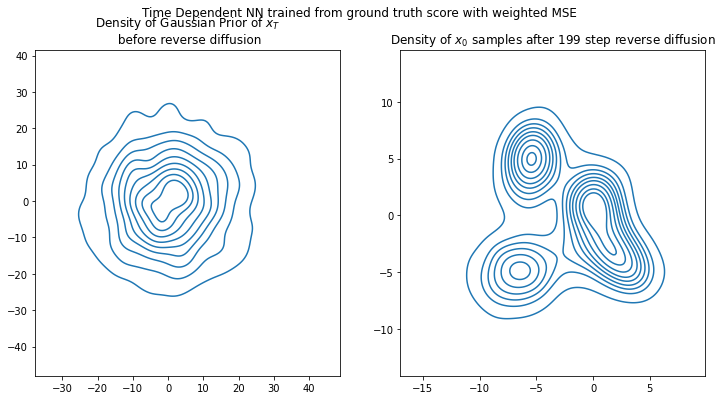

In [ ]:
x_traj_analyt3 = reverse_diffusion_time_dep(score_model_analy3, sampN=2000, sigma=25, nsteps=200, ndim=2, exact=False)
figh = visualize_diffusion_distr(x_traj_analyt3, explabel="Time Dependent NN trained from ground truth score with weighted MSE")

### Result Comparison 

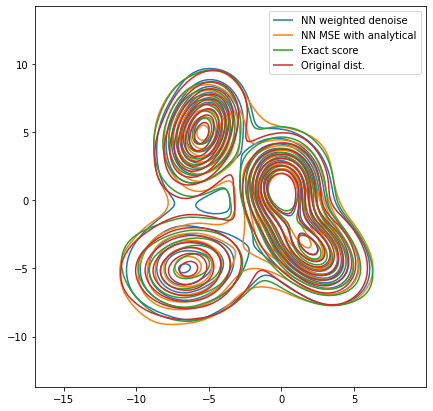

In [ ]:
fig, ax = plt.subplots(figsize=[7,7])
kdeplot(x_traj_denoise3[:,:,-1], label="NN weighted denoise")
kdeplot(x_traj_analyt3[:,:,-1], label="NN MSE with analytical")
kdeplot(x_traj_rev3[:,:,-1], label="Exact score")
kdeplot(gmm_samps3, label="Original dist.")
plt.axis("image")
plt.legend()
plt.show()

### Incorrect example: Approximating analytical score without time (NN Model)

In [ ]:
X_train3_T0, y_train3_T0, X_test3_T0, y_test3_T0 = \
  sample_X_and_score(gmm3, trainN=50000, testN=2000, )

In [ ]:
score_model_noT = ScoreModel_noTime()
optim = Adam(score_model_noT.parameters(), lr=0.001)
loss_fun = MSELoss()
pbar = tqdm.notebook.trange(500)
for ep in pbar:
  y_pred = score_model_noT(X_train3_T0)
  loss = loss_fun(y_train3_T0, y_pred)
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")
  if ep % 25==0:
    y_pred_test = score_model_noT(X_test3_T0)
    loss_test = loss_fun(y_test3_T0, y_pred_test)
    print(f"step {ep} test loss {loss.item():.3f}")

  0%|          | 0/500 [00:00<?, ?it/s]

step 0 loss 0.680
step 0 test loss 0.680
step 25 test loss 0.494
step 50 test loss 0.425
step 75 test loss 0.372
step 100 test loss 0.329
step 125 test loss 0.294
step 150 test loss 0.262
step 175 test loss 0.231
step 200 test loss 0.200
step 225 test loss 0.169
step 250 test loss 0.137
step 275 test loss 0.106
step 300 test loss 0.081
step 325 test loss 0.062
step 350 test loss 0.049
step 375 test loss 0.041
step 400 test loss 0.034
step 425 test loss 0.030
step 450 test loss 0.027
step 475 test loss 0.024


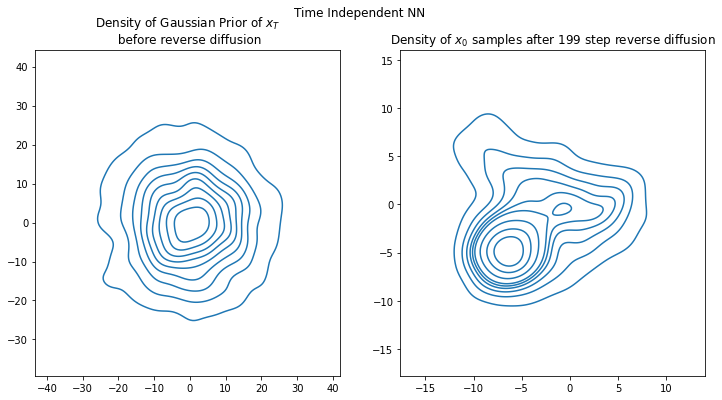

In [ ]:
x_traj_rev_noT = reverse_diffusion(score_model_noT, sampN=2000, sigma=25, nsteps=200, ndim=2)
figh = visualize_diffusion_distr(x_traj_rev_noT, explabel="Time Independent NN")

## Extra Application: Shape / Point cloud modelling

### Prepare point cloud dataset

In [ ]:
!git clone https://github.com/AnTao97/PointCloudDatasets.git

Cloning into 'PointCloudDatasets'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 43 (delta 14), reused 26 (delta 9), pack-reused 11
Unpacking objects: 100% (43/43), done.


In [ ]:
!wget -O shapenetpart_hdf5_2048.zip  https://cloud.tsinghua.edu.cn/f/c25d94e163454196a26b/?dl=1
!unzip shapenetpart_hdf5_2048.zip 
!mv shapenetpart_hdf5_2048 PointCloudDatasets/

--2022-06-22 19:41:12--  https://cloud.tsinghua.edu.cn/f/c25d94e163454196a26b/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/021833fc-5d88-444e-8806-8c270a43e620/shapenetpart_hdf5_2048.zip [following]
--2022-06-22 19:41:14--  https://cloud.tsinghua.edu.cn/seafhttp/files/021833fc-5d88-444e-8806-8c270a43e620/shapenetpart_hdf5_2048.zip
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 354818055 (338M) [application/zip]
Saving to: ‘shapenetpart_hdf5_2048.zip’

shapenetpart_hdf5_2 100%[===================>] 338.38M  25.0MB/s    in 15s     

2022-06-22 19:41:29 (22.1 MB/s) - ‘shapenetpart_hdf5_2048.zip’ saved [354818055/354818055]

Archive:  shapenetpart_hdf5_2048.zip
   creating: 

In [ ]:
%pwd
%cd PointCloudDatasets/
import sys
sys.path.append(r"/content/PointCloudDatasets")
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss
import torch.nn.functional as F
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

/content/PointCloudDatasets


In [ ]:
!python dataset.py

datasize: 12137
torch.Size([2048, 3]) torch.FloatTensor torch.Size([1]) torch.LongTensor airplane 02691156/points/d4d61a35e8b568fb7f1f82f6fc8747b8.pts


In [ ]:
from dataset import *
dataset_name = 'shapenetpart'
# choose split type from 'train', 'test', 'all', 'trainval' and 'val'
# only shapenetcorev2 and shapenetpart dataset support 'trainval' and 'val'
split = 'train'
rootdir = r"/content/PointCloudDatasets"
d = Dataset(root=rootdir, dataset_name=dataset_name, num_points=2048, split=split)

### Visualize Point Cloud

In [ ]:
pnts, label, name, fpath = d[15]
print(name, label)

chair tensor([4])


Text(0.5, 0, 'Z Label')

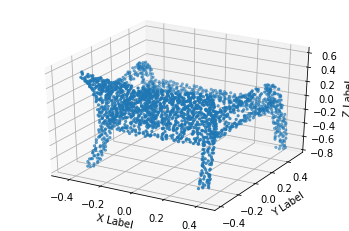

In [ ]:
fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = plt.axes(projection='3d')
xs, ys, zs = pnts[:,2], pnts[:,0], pnts[:,1]
ax.scatter(pnts[:,2], pnts[:,0], pnts[:,1], marker=".")
# ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# ax.axis("equal")

### Diffusion model for 3d shapes

Now let's generalize our model to 3d, and model some 3d point cloud dataset by diffusion modelling. 

In [ ]:
class ScoreModel_Time3d(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ndim=3):
    super().__init__()
    ...

In [ ]:
scales = pnts.std(dim=0, keepdim=True)
X_train_tsr = pnts / scales

In [ ]:
# define your training loop
sigma = ...
score_model_td = ScoreModel_Time3d(sigma=sigma)
score_model_td.train()
pbar = tqdm.notebook.trange(1000)
for ep in pbar:
  ...
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")

## Extra Application: Image Modelling

[MNIST modelling per Song Yang](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing)